# Spectral Clustering — End-to-End Sanity Check (CPU by default)

This notebook serves two purposes:

1. **Sanity check**: run all core functions to ensure the repo is consistent after refactor.
2. **Showcase**: demonstrate spectral recovery of block structure from a shuffled adjacency matrix.

**CPU by default**. If you have CuPy + CUDA, a final cell is provided to try the GPU path once.

**Matrix size**: we use a 100×100 graph (4 groups × 25 nodes), which is reasonable for modern machines.


In [1]:
# Setup paths and imports (CPU by default)
from pathlib import Path
import sys, numpy as np, matplotlib.pyplot as plt

ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

from graph_models import generate_multi_group_laplacian
from SCOPE import sparse_score, matrixtype, eigen_decomposition, best_cut_finder, bicut_group, treebuilder

print("Project root:", ROOT)
print("Modules imported successfully.")

Project root: h:\Personal Projects\Spectral-Clustering
Modules imported successfully.


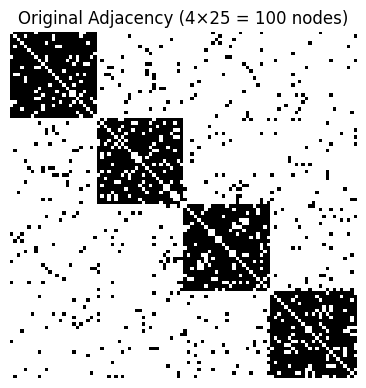

L shape: (100, 100) A shape: (100, 100)
Sparsity score: 0.2472


In [2]:
# Generate a 100x100 Laplacian (4 groups × 25 nodes)
num_groups, group_size = 4, 25
prob_within, prob_between = 0.85, 0.05

L = generate_multi_group_laplacian(num_groups, group_size, prob_within, prob_between)
A = np.diag(np.diag(L)) - L

plt.figure(figsize=(4.5,4.5))
plt.imshow(A, cmap='binary', interpolation='none')
plt.title("Original Adjacency (4×25 = 100 nodes)")
plt.axis('off')
plt.show()

print("L shape:", L.shape, "A shape:", A.shape)
print("Sparsity score:", sparse_score(L))


In [3]:
# Core function checks: matrixtype (CPU dense), eigen_decomposition (k=3), best_cut_finder
L_cpu_dense = matrixtype(L, gpu=False, sparse=False)
print("matrixtype -> CPU dense shape:", L_cpu_dense.shape, type(L_cpu_dense))

# eigen_decomposition returns the spectral vector (Fiedler when k=2). Here we ask for k=3.
v = eigen_decomposition(L_cpu_dense, gpu=False, sparse=False, k=3)
print("eigen_decomposition returned vector shape:", np.shape(v))

cut_idx = best_cut_finder(L_cpu_dense, gpu=False, sparse=False)
print("best_cut_finder -> cut index (1-based):", cut_idx)


matrixtype -> CPU dense shape: (100, 100) <class 'numpy.ndarray'>
eigen_decomposition returned vector shape: (100,)
best_cut_finder -> cut index (1-based): 1


In [4]:
# Recursive tree builder (non-parallel for determinism in this demo)
root = treebuilder(L_cpu_dense, thre=30, parallel=False)
print("Tree built successfully. Root node:", root)


Tree built successfully. Root node: <SCOPE.BiCutNode object at 0x00000267BEEE5040>


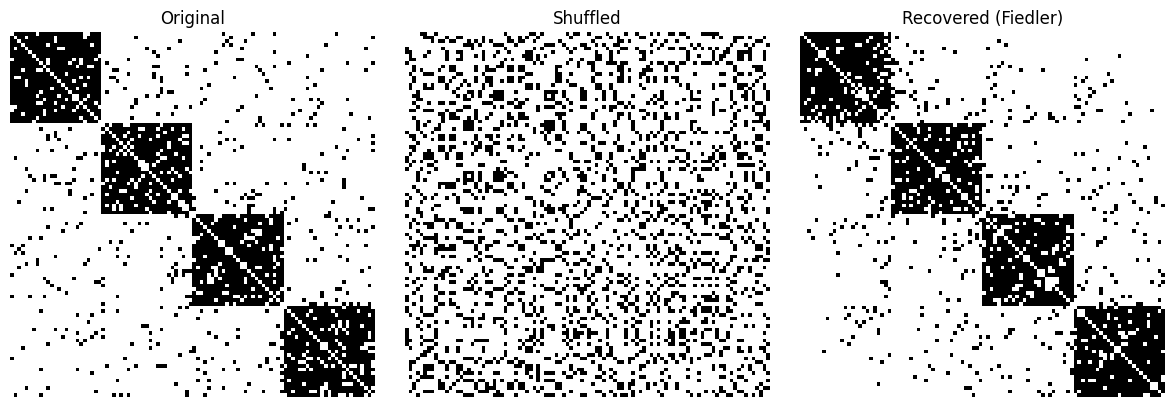

In [5]:
# Spectral recovery demo: original -> shuffled -> recovered (Fiedler order)
def fiedler_order(L_):
    v = eigen_decomposition(L_, gpu=False, sparse=False, k=2)
    f = np.asarray(v).flatten()
    return np.argsort(f)

perm = np.random.permutation(A.shape[0])
A_shuf = A[perm][:, perm]
L_shuf = np.diag(A_shuf.sum(axis=1)) - A_shuf

order = fiedler_order(L_shuf)
A_rec = A_shuf[order][:, order]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(A, cmap='binary', interpolation='none'); axs[0].set_title("Original"); axs[0].axis('off')
axs[1].imshow(A_shuf, cmap='binary', interpolation='none'); axs[1].set_title("Shuffled"); axs[1].axis('off')
axs[2].imshow(A_rec, cmap='binary', interpolation='none'); axs[2].set_title("Recovered (Fiedler)"); axs[2].axis('off')
plt.tight_layout(); plt.show()


### Optional: GPU sanity check (CuPy)
Run this cell if you have CuPy + CUDA installed.

In [6]:
# Optional GPU check (safe to skip if CuPy/CUDA not installed)
try:
    import cupy as cp
    L_gpu = matrixtype(L, gpu=True, sparse=False)
    v_gpu = eigen_decomposition(L_gpu, gpu=True, sparse=False, k=2)
    print("GPU eigen vector length:", len(v_gpu))
except Exception as e:
    print("GPU test skipped or failed:", e)


GPU eigen vector length: 100
